In [1]:
# 1. Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

In [2]:
# 2. Load the Data
train = pd.read_csv("train.csv")
train

,id,campaign_id,coupon_id,customer_id,redemption_status
0,1,13,27,1053,0
1,2,13,116,48,0
2,6,9,635,205,0
3,7,13,644,1050,0
4,9,8,1017,1489,0
...,...,...,...,...,...
78364,128587,8,71,1523,0
78365,128589,30,547,937,0
78366,128590,8,754,1004,0
78367,128592,13,134,71,0


In [3]:
campaign_data = pd.read_csv("campaign_data.csv")
campaign_data

,campaign_id,campaign_type,start_date,end_date
0,24,Y,21/10/13,20/12/13
1,25,Y,21/10/13,22/11/13
2,20,Y,07/09/13,16/11/13
3,23,Y,08/10/13,15/11/13
4,21,Y,16/09/13,18/10/13
5,22,X,16/09/13,18/10/13
6,18,X,10/08/13,04/10/13
7,19,Y,26/08/13,27/09/13
8,17,Y,29/07/13,30/08/13
9,16,Y,15/07/13,16/08/13


In [4]:
coupon_item_mapping = pd.read_csv("coupon_item_mapping.csv")
coupon_item_mapping

,coupon_id,item_id
0,105,37
1,107,75
2,494,76
3,522,77
4,518,77
...,...,...
92658,32,69268
92659,32,68502
92660,32,68612
92661,33,71390


In [5]:
customer_demographics = pd.read_csv("customer_demographics.csv")
customer_demographics

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,NaN,4
1,6,46-55,Married,0,2,NaN,5
2,7,26-35,NaN,0,3,1,3
3,8,26-35,NaN,0,4,2,6
4,10,46-55,Single,0,1,NaN,5
...,...,...,...,...,...,...,...
755,1577,36-45,NaN,0,2,NaN,5
756,1578,46-55,Married,0,3,1,6
757,1579,46-55,NaN,0,1,NaN,4
758,1580,26-35,NaN,0,2,NaN,5


In [6]:
customer_transaction_data = pd.read_csv("customer_transaction_data.csv")
customer_transaction_data

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0
1,2012-01-02,1501,54253,1,53.43,-13.89,0.0
2,2012-01-02,1501,31962,1,106.50,-14.25,0.0
3,2012-01-02,1501,33647,1,67.32,0.00,0.0
4,2012-01-02,1501,48199,1,71.24,-28.14,0.0
...,...,...,...,...,...,...,...
1324561,2013-06-30,1129,2777,1,284.60,-71.24,0.0
1324562,2013-06-30,1129,2953,4,42.74,-28.50,0.0
1324563,2013-06-30,1129,2971,6,64.12,-42.74,0.0
1324564,2013-06-30,1129,46984,1,95.82,0.00,0.0


In [7]:
item_data = pd.read_csv("item_data.csv")
item_data

,item_id,brand,brand_type,category
0,1,1,Established,Grocery
1,2,1,Established,Miscellaneous
2,3,56,Local,Bakery
3,4,56,Local,Grocery
4,5,56,Local,Grocery
...,...,...,...,...
74061,74062,5490,Established,Pharmaceutical
74062,74063,5497,Established,Pharmaceutical
74063,74064,5497,Established,Pharmaceutical
74064,74065,5520,Established,Pharmaceutical


In [8]:
# 3. Data Preprocessing & Merging
df = train.merge(campaign_data, on="campaign_id", how="left")
df = df.merge(customer_demographics, on="customer_id", how="left")
df = df.merge(coupon_item_mapping, on="coupon_id", how="left")
df = df.merge(item_data, on="item_id", how="left")

trans_agg = customer_transaction_data.groupby("customer_id").agg({
    "quantity": "sum",
    "selling_price": "mean",
    "other_discount": "mean",
    "coupon_discount": "mean"
}).reset_index()
trans_agg.columns = ["customer_id", "total_quantity", "avg_price", "avg_other_discount", "avg_coupon_discount"]

df = df.merge(trans_agg, on="customer_id", how="left")

In [9]:
# Campaign duration
df["start_date"] = pd.to_datetime(df["start_date"])
df["end_date"] = pd.to_datetime(df["end_date"])
df["campaign_duration"] = (df["end_date"] - df["start_date"]).dt.days

df.drop(["id", "start_date", "end_date"], axis=1, inplace=True)

In [10]:
# 4. Encode Categorical + Fix Range Strings
# =======================================
if 'family_size' in df.columns:
    df['family_size'] = df['family_size'].replace('5+', 5)
    df['family_size'] = df['family_size'].fillna(0).astype(int)

if 'no_of_children' in df.columns:
    df['no_of_children'] = df['no_of_children'].replace('3+', 3)
    df['no_of_children'] = df['no_of_children'].fillna(0).astype(int)

In [11]:
# Convert income bracket to numeric safely
df['income_bracket'] = pd.to_numeric(df['income_bracket'], errors='coerce')
df['income_bracket'] = df['income_bracket'].fillna(0)

In [12]:
# Encode categoricals
cat_cols = ["campaign_type", "age_range", "marital_status", "rented", "brand", "brand_type", "category"]
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

In [13]:
# Final fill for any leftovers
df.fillna(0, inplace=True)

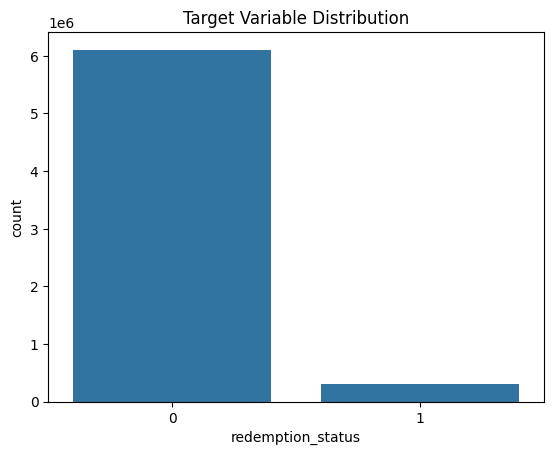

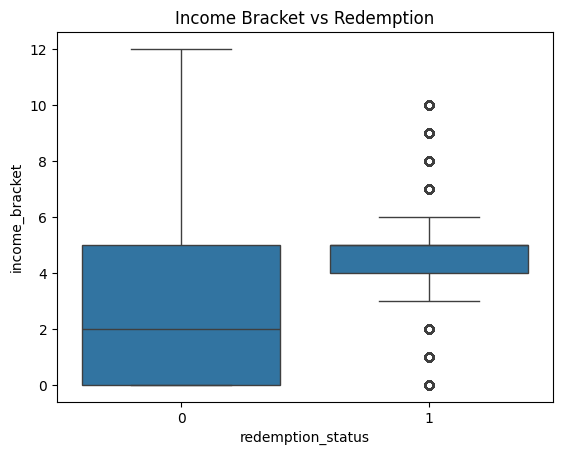

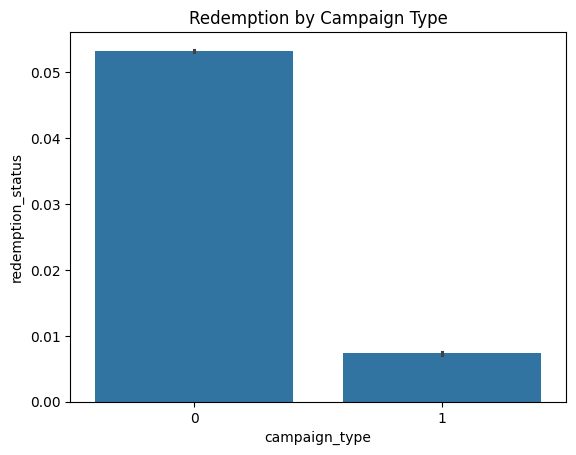

In [14]:
# 5. Visual Analysis
sns.countplot(x='redemption_status', data=df)
plt.title("Target Variable Distribution")
plt.show()

sns.boxplot(x='redemption_status', y='income_bracket', data=df)
plt.title("Income Bracket vs Redemption")
plt.show()

sns.barplot(x='campaign_type', y='redemption_status', data=df)
plt.title("Redemption by Campaign Type")
plt.show()

In [15]:
# 6. Modeling
X = df.drop("redemption_status", axis=1)
y = df["redemption_status"]

In [16]:
# Resample
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

In [18]:
# Train models
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_model.fit(X_res, y_res)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [19]:
dt_model = DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42)
dt_model.fit(X_res, y_res)

DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=42)

In [20]:
# Evaluate
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
y_pred_lr = lr_model.predict(X_test)
y_pred_dt = dt_model.predict(X_test)

In [21]:
# Logistic Regression
print("\nLogistic Regression:")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, lr_model.predict_proba(X_test)[:,1]))


Logistic Regression:
              precision    recall  f1-score   support

           0       0.98      0.73      0.84   1221633
           1       0.12      0.76      0.21     62506

    accuracy                           0.73   1284139
   macro avg       0.55      0.74      0.52   1284139
weighted avg       0.94      0.73      0.80   1284139

ROC-AUC: 0.8037931031911524


In [22]:
#Decision Tree
print("\nDecision Tree:")
print(classification_report(y_test, y_pred_dt))
print("ROC-AUC:", roc_auc_score(y_test, dt_model.predict_proba(X_test)[:,1]))


Decision Tree:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91   1221633
           1       0.22      0.96      0.36     62506

    accuracy                           0.84   1284139
   macro avg       0.61      0.89      0.64   1284139
weighted avg       0.96      0.84      0.88   1284139

ROC-AUC: 0.9412262596854435


In [23]:
# 7. Feature Importance
lr_importance = pd.Series(lr_model.coef_[0], index=X.columns).sort_values(ascending=False)
dt_importance = pd.Series(dt_model.feature_importances_, index=X.columns).sort_values(ascending=False)

print("\nTop Logistic Regression Features:")
print(lr_importance.head(10))

print("\nTop Decision Tree Features:")
print(dt_importance.head(10))


Top Logistic Regression Features:
income_bracket       0.191046
family_size          0.060775
campaign_id          0.019145
no_of_children       0.000492
customer_id          0.000461
brand                0.000068
item_id              0.000002
total_quantity       0.000002
coupon_id           -0.001660
campaign_duration   -0.002263
dtype: float64

Top Decision Tree Features:
avg_coupon_discount    0.645675
coupon_id              0.096379
income_bracket         0.078234
avg_other_discount     0.045280
category               0.039525
avg_price              0.030041
total_quantity         0.025941
age_range              0.019045
campaign_type          0.010371
brand_type             0.006633
dtype: float64


In [25]:
# Save model and column names
import joblib
joblib.dump(lr_model, "coupon_redemption_api/model/logistic_model.pkl")
joblib.dump(X_res.columns.tolist(), "coupon_redemption_api/model/feature_columns.pkl")

['coupon_redemption_api/model/feature_columns.pkl']